Step 1: Install Required Libraries

In [1]:
!pip install optuna category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.6 MB/s eta 0:00:00


Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Step 3: Load the Dataset

The dataset is loaded from a CSV file. Missing values are handled immediately to ensure data consistency.

In [3]:
file_path = "/content/CESAW_Defect_fact_merged.csv"
data = pd.read_csv(file_path)

# Remove missing values
data.dropna(inplace=True)

print(f" Dataset Loaded! Shape: {data.shape}")

 Dataset Loaded! Shape: (1000, 10)


Step 4: Select Features

Here, I define which numerical and categorical features are relevant for training the model.

Categorical variables require encoding before being used in the model.

In [4]:
# Define numerical and categorical features
numerical_features = [
    "defect_fix_time_minutes", "size_added", "size_deleted",
    "size_modified", "effort_hours", "complexity_score", "testing_coverage"
]
categorical_features = ["team_key"]

# Separate features and target variable
X = data[numerical_features + categorical_features]
y = data["defect_count"]  # The variable we are predicting

Step 5: Feature Engineering (Encoding Categorical Features)

Since team_key is a categorical feature, it needs to be converted into a numerical format.

Instead of one-hot encoding (which creates many columns), we use Target Encoding, which replaces each category with the mean target value.

In [5]:
# Convert 'team_key' to string to ensure it's recognized as categorical
X.loc[:, "team_key"] = X["team_key"].astype(str)

# Apply Target Encoding and handle missing values (if any)
encoder = TargetEncoder()
X_encoded = encoder.fit_transform(X[["team_key"]], y).fillna(0)

# Replace original categorical column with encoded version
X = X.drop(columns=["team_key"]).join(pd.DataFrame(X_encoded, columns=["team_key_encoded"], index=X.index))

print("Target Encoding Applied Successfully")

Target Encoding Applied Successfully


<ipython-input-5-addecdb4b420>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2' '13' '6' '5' '1' '6' '6' '16' '4' '11' '9' '3' '19' '8' '5' '4' '6'
 '2' '11' '4' '15' '6' '17' '6' '19' '2' '15' '11' '8' '19' '13' '12' '5'
 '6' '4' '19' '1' '17' '12' '15' '1' '14' '6' '5' '11' '4' '13' '11' '3'
 '1' '6' '18' '10' '5' '10' '12' '2' '13' '8' '2' '1' '5' '9' '17' '9'
 '11' '15' '6' '3' '17' '5' '12' '18' '14' '11' '9' '2' '12' '3' '3' '1'
 '8' '8' '11' '9' '5' '14' '3' '5' '5' '19' '14' '4' '13' '10' '18' '8'
 '8' '7' '8' '14' '19' '6' '1' '15' '1' '17' '1' '15' '2' '14' '8' '8'
 '19' '7' '19' '6' '6' '3' '7' '19' '8' '10' '15' '15' '1' '7' '4' '6' '1'
 '5' '1' '4' '2' '10' '5' '10' '1' '6' '13' '15' '4' '13' '15' '8' '5'
 '15' '4' '12' '13' '2' '19' '19' '4' '4' '11' '5' '11' '10' '8' '6' '6'
 '8' '15' '14' '11' '12' '13' '8' '18' '1' '15' '8' '11' '12' '12' '4'
 '16' '4' '5' '5' '8' '10' '17' '9' '19' '14' '8' '

Step 6: Split Dataset into Training & Testing Sets

Splitting the dataset ensures that we train the model on 80% of the data and test it on the remaining 20%.

Helps evaluate how well the model generalizes to unseen data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Split Completed: {X_train.shape[0]} training rows, {X_test.shape[0]} testing rows")

Data Split Completed: 800 training rows, 200 testing rows


Step 7: Handle Missing Values (Final Check)

Ensures that there are no missing values before scaling and training the model.

In [7]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
print("No missing values in training or testing data")

No missing values in training or testing data


Step 8: Scale the Data

Standardizing the numerical features helps improve model performance.

I use StandardScaler, which transforms features so they have a mean of 0 and a standard deviation of 1.

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features Scaled Successfully")

Features Scaled Successfully


Step 9: Define Base Models.

Instead of using just one model, we use multiple models (RandomForest, XGBoost, GradientBoosting, LightGBM) to create a stronger prediction system.

In [9]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_split=10, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.05, gamma=0.1, reg_lambda=2.0, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42)),
    ('lgb', LGBMRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, random_state=42))
]

print("Base Models Defined")

Base Models Defined


Step 10: Define Meta-Model.

A meta-model is trained on the outputs of the base models to make the final prediction.

We use ElasticNet, which applies regularization to prevent overfitting.

In [10]:
meta_model = ElasticNet(alpha=0.5, l1_ratio=0.5)  # Balanced L1/L2 regularization

print("Meta-Model Initialized")

Meta-Model Initialized


Step 11: Create Stacking Model.

This model combines multiple base models and the meta-model for better accuracy.

In [11]:
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=StratifiedKFold(n_splits=5))

print("Stacking Model Created")

Stacking Model Created


Step 12: Train the Model.

I now train the full stacking model on the training dataset.

In [12]:
print("Training the Stacking Model...")
stacked_model.fit(X_train_scaled, y_train)

print("Model Training Completed")

Training the Stacking Model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 7
[LightGBM] [Info] Start training from score 31.365000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packag

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 7
[LightGBM] [Info] Start training from score 31.337500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 13: Evaluate the Model.

I now test the model on unseen data and calculate common regression evaluation metrics.

In [13]:
y_pred = stacked_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Results:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Model Evaluation Results:
MAE: 2.92
MSE: 13.43
RMSE: 3.67
R² Score: 0.82


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Step 14: Save the Model and Preprocessing Tools.

The trained model and encoders are saved for future use in the API.

In [14]:
joblib.dump(stacked_model, "optimized_defect_prediction_model.pkl")
joblib.dump(scaler, "defect_preprocessor.pkl")
joblib.dump(encoder, "defect_encoder.pkl")

print("Model and Preprocessors Saved")

Model and Preprocessors Saved


Step 15: Save Model Performance Metrics.

To track how well the model performs, I store the evaluation metrics separately.

In [15]:
defect_metrics = {
    "r2_score": round(r2, 4),
    "mae": round(mae, 2),
    "rmse": round(rmse, 2)
}

joblib.dump(defect_metrics, "defect_prediction_metrics.pkl")
print("Defect Prediction Metrics Saved")

Defect Prediction Metrics Saved


Step 16: Visualize the Model's Performance.

To understand how well the model is predicting, I plot actual vs predicted values.

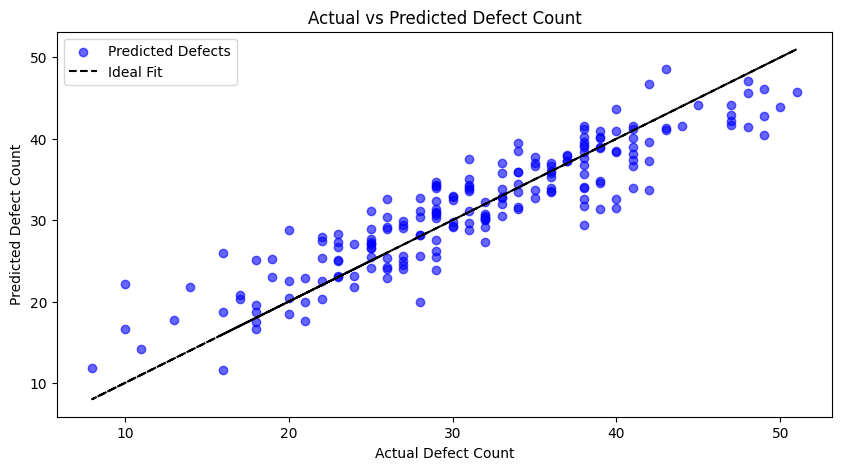

Model Performance Visualization Completed


In [16]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, label="Predicted Defects", alpha=0.6, color='blue')
plt.plot(y_test, y_test, 'k--', label="Ideal Fit")
plt.xlabel("Actual Defect Count")
plt.ylabel("Predicted Defect Count")
plt.legend()
plt.title("Actual vs Predicted Defect Count")
plt.show()

print("Model Performance Visualization Completed")